# Detección de genomas anómalos de SARS-CoV-2 por medio de algoritmos de aprendizaje no supervisados 

# Conjunto de datos

El conjunto de datos crudo se obtuvo de [GISAID](https://gisaid.org), donde cada linea dentro del archivo (secuencia de texto de abajo) define la secuencia de nucleótidos para un gen en específico (espiga, membrana, envoltura, etc.), así como otros datos particulares del virus SARS-CoV-2 proveniente (fecha, estado, institucion de secuenciación, etiqueta de virus proveniente, etc.). En esta sección se describe el preprocesamiento y limpieza realizados a este conjunto de datos, donde el objetivo es obtener la representación de el genoma completo de cada virus representado como su uso de codones, además de obtener los metadatos más relevantes de la secuencia (tabla de abajo). Por lo que el archivo de datos resultante despues de realizar de este preprocesamiento es finalmente utilizado para realizar el analisis planteado en el capítulo 1. El código requerido para realizar el procediento se encuentra en este archivo.

![](Images/secuencia_cruda.png)

![](Imagenes/secuencia_preprocesada.png)

___

## Preprocesamiento y extracción del uso de codones

En la primera parte de este Jupyter Notebook se presenta el código necesario para obtener los datos a utilizar a partir de los datos crudos. Dentro del archivo ```mex_seqsmex_seqs.csv``` (datos crudos) cada cadena representa un gen secuenciado (cadenas con secuencias de aminoácidos) y los metadatos respectivos de cada secuencia.

En la primera parte del Notebook se toman esas cadenas con el fin de construir una tabla que muestre el uso de codones de cada gen. Además de obtener columnas con descripciones como estado de origen, fecha, nombre del gen, nombre del virus, etc.

Los datos se obtienen dependiendo del tamaño de la secuencia, como se muestra en la siguiente figura.

![kindOfRows](Images/kindOfRows.png)

### ➤ Bibliotecas necesarias y configuración inicial

Para realizar el pre-procesamiento de estos datos solo fue necesario utilizar las bibliotecas ```numpy```, ```pandas```, y ```matplotlib``` para la visualización.

In [1]:
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd

In [2]:
BACK = 'white'
FRONT = (230/255,236/255,245/255)

plt.rc('figure', facecolor=BACK, edgecolor='white')
plt.rc('axes', facecolor=FRONT, edgecolor='white', labelsize=14, labelweight='medium', titlesize=18, grid=True, axisbelow=True)
plt.rc('grid', color='white')

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 16)

### ➤ Funciones a utilizar

#### • Filtrado de las fechas

In [3]:
# Funcion para filtrar las fechas xxxx-00-00 por xxxx-01-01 
# y las fechas xxxx-xx-00 por xxxx-xx-01.
def formatDate(date):
    if '-00-00' in date:
        date = date[:4] + '-01-01'
    if '-00' in date:
        date = date[:7] + '-01'
    return pd.Timestamp(date)

#### • Filtrado de los estados

Cadenas únicas dentro del archivo que codifican el estado de procedencia del gen secuenciado.

![UniqueStringStates](Images/UniqueStringStates.png)

In [4]:
# Funcion para filtrar los estados posibles. Toma los estados sinónimos y 
# regresa la llave respectiva, si la cadena no se encuentra en los 
# valores del diccionario regresa 'Desconocido'.
def formatState(state):
    # Diccionario con cadenas equivalentes. Cualquier sinónimo pasa 
    # a tomar el valor de la llave de su diccionario respectivo.
    states_name = {'Aguascalientes':['Aguascalientes', 'Aguascallientes'],
                'Baja California Norte':['Baja California', 'Baja California Norte'], 
                'Baja California Sur':['Baja California Sur'],
                'Ciudad de México':['CDMX', 'CMX', 'Ciudad De México', 'Ciudad de Mexico', 
                                   'Distrito Federal', 'Mexico City', 'Mexico city'],
                'Campeche':['Campeche'], 
                'Chiapas':['Chiapas'], 
                'Chihuahua':['Chihuahua'], 
                'Coahuila':['Coahuila', 'Coahuila de Zaragoza'], 
                'Colima':['Colima'], 
                'Durango':['Durango'], 
                'Estado de Mexico':['Edomex', 'Estado de Mexico', 'State of Mexico', 
                                   'State of mexico', 'Stated of Mexico'], 
                'Guanajuato':['Guanajuato'], 
                'Guerrero':['Guerrero', 'Guerero'], 
                'Hidalgo':['Hidalgo'], 
                'Jalisco':['Jalisco'], 
                'Michoacán':['Michoacan', 'Michoacán', 'Michocan'], 
                'Morelos':['Morelos'], 
                'Nayarit':['Nayarit'],
                'Nuevo Leon':['Nuevo Leon'],
                'Oaxaca':['Oaxaca'],
                'Puebla':['Puebla'], 
                'Queretaro':['Queretaro'], 
                'Quintana Roo':['Quinatan Roo', 'Quintana Roo', 'Cancun'], 
                'San Luis Potosi':['San Luis Potosi'], 
                'Sinaloa':['Sinaloa'], 
                'Sonora':['Sonora', 'Sonoramx'], 
                'Tabasco':['Tabasco'], 
                'Tamaulipas':['Tamaulipas'], 
                'Tlaxcala':['Tlaxcala'], 
                'Veracruz':['Veracruz'], 
                'Yucatán':['Yucatan', 'Yucatán', 'Mérida'], 
                'Zacatecas':['Zacatecas']}
    # Regresa el mismo valor si este es Desconocido
    if state == 'Desconocido':
        return state
    # Se obtiene solo el nombre del estado
    state = state.split('^^')[1]
    state = state.replace('\\','', 1)
    state = bytes(state, "utf-8").decode('unicode-escape')
    
    # Para cada nombre de estado regresa la cadena equivalente 
    for state_name, other_names in states_name.items():
        if state in other_names:
            return state_name
    
    # Si no encuentra el nombre del estado en el diccionario
    return 'Desconocido'

#### • Filtrado de secuencias de codones

Primero se obtiene la secuencia completa de aminoácidos de cada cadena de los datos crudos, luego se recorre esta secuencia de tres en tres caracteres obteniendo el número de codon (por medio del diccionario ```codon_number```) y contabilizando estos. Cualquier error, marcado por la aparición de la letra ```N```, se cuentan aparte.

![sequence](Images/sequence.png)

In [5]:
# Funcion para filtrar las secuencias de codones.
def formatSequence(sequence):
    # Diccionario de numero de codon
    codons_number = {'AAA': 0, 'AAC': 1, 'AAG': 2, 'AAT': 3, 'ACA': 4, 'ACC': 5, 'ACG': 6, 'ACT': 7, 
                     'AGA': 8, 'AGC': 9, 'AGG': 10, 'AGT': 11, 'ATA': 12, 'ATC': 13, 'ATG': 14, 'ATT': 15, 
                     'CAA': 16, 'CAC': 17, 'CAG': 18, 'CAT': 19, 'CCA': 20, 'CCC': 21, 'CCG': 22, 'CCT': 23, 
                     'CGA': 24, 'CGC': 25, 'CGG': 26, 'CGT': 27, 'CTA': 28, 'CTC': 29, 'CTG': 30, 'CTT': 31, 
                     'GAA': 32, 'GAC': 33, 'GAG': 34, 'GAT': 35, 'GCA': 36, 'GCC': 37, 'GCG': 38, 'GCT': 39, 
                     'GGA': 40, 'GGC': 41, 'GGG': 42, 'GGT': 43, 'GTA': 44, 'GTC': 45, 'GTG': 46, 'GTT': 47, 
                     'TAA': 48, 'TAC': 49, 'TAG': 50, 'TAT': 51, 'TCA': 52, 'TCC': 53, 'TCG': 54, 'TCT': 55, 
                     'TGA': 56, 'TGC': 57, 'TGG': 58, 'TGT': 59, 'TTA': 60, 'TTC': 61, 'TTG': 62, 'TTT': 63}
    # Se obtiene solamente la secuencia de nucleotidos
    _, sequence = sequence.split("'")
    sequence = sequence.replace('\n','')
    # Tamano de un codon
    CODON_LEGNTH = 3
    # Diccionario para guardar el conteo de cada codon
    codon_bias = {i:0 for i in range(64)}
    # Valores iniciales
    n = len(sequence)
    codons = 0
    errors = 0
    # Cuenta la aparición de cada codon en la secuencia
    # y los errores encontrados en la secuencia
    for i in range(0,n,CODON_LEGNTH):
        codon = sequence[i:i+CODON_LEGNTH]
        if codon in codons_number:
            number = codons_number[codon]
            codon_bias[number] += 1
            codons += 1
        else:
            errors += 1
    # Anade conteos globales
    codon_bias['Errors'] = errors       
    codon_bias['Codons'] = codons
    return codon_bias

#### • Filtrado de descripción de la secuencia

In [6]:
# Funcion para obtener la descripción de cada cadena.
def formatDescription(description):
    return description.split('/')[2]

### ➤ Código de preprocesamiento

El siguiente código muestra el preprocesamiento realizado a cada secuencia contenida en el archivo de datos crudo.

In [7]:
data = {'Gene_Name':[], 'Description':[], 'Date':[], 'State':[], 'Virus':[]}
codon_bias = []

with open('Archivos_crudos/mex_seqs.csv') as raw_data:
    
    # Toma las lineas del archivo (cada linea es una secuecia de un gen)
    raw_data_lines = raw_data.readlines()
    
    # Se filtra cada linea obtenida
    for i,row in enumerate(raw_data_lines):
        
        # Separa la linea con un delimitador definido
        row_list = row.split('|')
        
        # El procedimiento cambia si la lista resultante 
        # es de una longitud diferente a 5
        if len(row_list) == 5:
            # gene (index=0), description (index=1), variant (index=2),
            # date (index=3), sequence (index=4)
            gene, description, variant, date, sequence = row_list
            state = 'Desconocido'
        else:
            # Gene (index=0), description (index=1), date (index=2),
            # variant (index=3), state (index=5), sequence (index=-1)
            gene, description, date, variant, _, state, *_, sequence = row_list
            
        # Se filtran todos los atributos utilizando funciones previamente definidas
        # y se agregan a un diccionario
        data['Gene_Name'].append(gene[3:])
        data['Description'].append(formatDescription(description))
        data['Date'].append(formatDate(date))
        data['Virus'].append(variant)
        data['State'].append(formatState(state))
        
        codon_bias.append(formatSequence(sequence))
    
    del raw_data_lines, row, row_list

# Se crea un conjunto de datos con las diferentes secuencias de cada gen
codonFrame = pd.DataFrame(codon_bias)
descriptionFrame = pd.DataFrame(data)
dataset = pd.merge(descriptionFrame,codonFrame, left_index=True, right_index=True)

Una vez preprocesada cada secuencia, se forma una tabla con de $1,415,436$ renglones. Cada renglon representa tanto datos desciptivos como el uso de codones característico de cada gen contenido en el archivo sin preprocesar (tabla de abajo).

In [8]:
dataset

,Gene_Name,Description,Date,State,Virus,0,1,2,...,58,59,60,61,62,63,Errors,Codons
0,Spike,CMX-INMEGEN-12-04-10,2020-11-23,Ciudad de México,EPI_ISL_1005568,39,34,23,...,12,28,28,18,20,59,0,1274
1,Spike,CMX-INMEGEN-12-04-05,2020-12-21,Ciudad de México,EPI_ISL_1005563,39,34,23,...,12,28,28,18,20,59,0,1274
2,Spike,CMX-INMEGEN-12-04-18,2020-12-23,Ciudad de México,EPI_ISL_1005576,38,34,23,...,12,28,28,18,20,59,0,1274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415433,N,MEX-UGA_HRAEI_SSA_0402,2022-02-21,Estado de Mexico,EPI_ISL_13560138,22,6,10,...,5,0,2,10,9,3,0,417
1415434,NS9b,MEX-UGA_HRAEI_SSA_0402,2022-02-21,Estado de Mexico,EPI_ISL_13560138,3,3,3,...,0,0,3,2,2,0,0,95
1415435,NS9c,MEX-UGA_HRAEI_SSA_0402,2022-02-21,Estado de Mexico,EPI_ISL_13560138,0,2,4,...,1,0,0,1,2,0,0,74


## ➤ Obtención del genoma completo y limpieza de datos

Una vez generada la tabla de uso de codones para cada gen es necesario encontrar que virus cuentan con el genoma completo, es decir, si los 27 genes del virus existen y están completamente secuenciados. Si este es el caso, los renglones de la tabla se agrupan para generar una sola instancia que represente el genoma completo del virus. 

Para realizar esto es necesario encontrar el número de genes por cada virus.

### • Valores únicos

Se obtienen los valores únicos de las columnas que contienen a los metadatos (```dtype!='int64'```).

In [9]:
dataset.select_dtypes(exclude='int64').nunique()

Gene_Name         27
Description    63477
Date             824
State             33
Virus          63728
dtype: int64

Los valores únicos de estas columnas son los siguientes:

- 27 diferentes nombres de genes. (Los 27 genes diferentes esperados)
- 63477 lugares donde se obtuvieron los datos.
- 824 días diferentes.
- 33 categorías para estado.
- 63728 virus.

### • Agrupación de los datos por virus

Se realiza una agrupación de los datos por el nombre de los 63728 virus. Esto con el fin de encontrar aquellos virus que si se componen de los 27 genes diferentes.

In [10]:
viruses = (
    dataset
    [['Virus','Gene_Name']]
    .groupby(by='Virus', as_index=False)
    .count()
    .rename(columns={'Gene_Name':'Gene_Count'})
)
viruses

,Virus,Gene_Count
0,EPI_ISL_10026752,27
1,EPI_ISL_10027182,27
2,EPI_ISL_10027505,27
...,...,...
63725,EPI_ISL_9988334,27
63726,EPI_ISL_9988335,27
63727,EPI_ISL_9988336,27


Se obtiene una visualización del número total de virus según la cantidad de genes de los mismos.

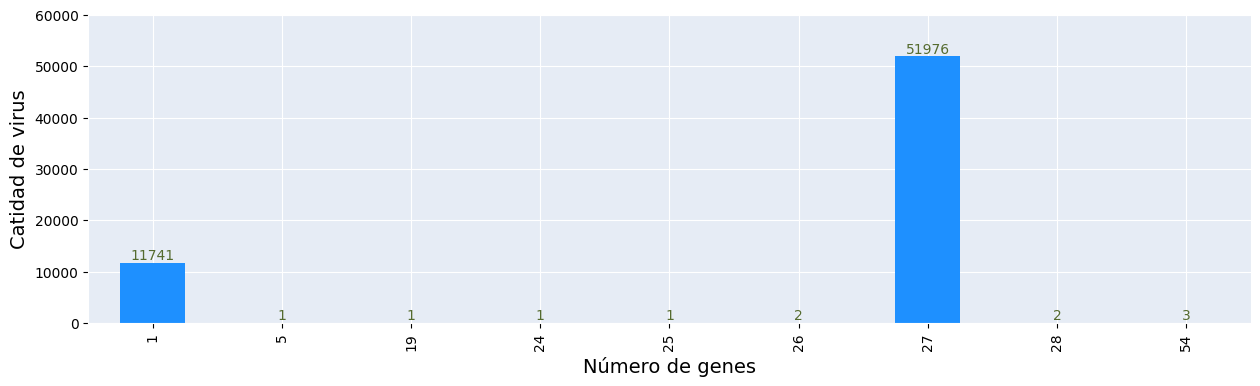

In [11]:
fig, ax = plt.subplots(figsize=(15,4))
bar = (
    viruses
    .groupby(by='Gene_Count', as_index=False)
    .count()
    .plot.bar(x='Gene_Count', y='Virus', color='dodgerblue', legend=False, ylabel='Catidad de virus', xlabel='Número de genes', ax=ax)
)
ax.set_ylim(0, 60000)
ax.bar_label(bar.containers[0], color='darkolivegreen');

En esta se puede observar como solo 51976 virus, de los 63728, tienen el número de genes correctos, por lo que solo se conservaran esos.

### • Selección de instancias a utilizar

Se obtienen los virus que cumplen con tener exactamente 27 genes.

In [12]:
valid_viruses = viruses.query('Gene_Count == 27')['Virus']
valid_viruses

0        EPI_ISL_10026752
1        EPI_ISL_10027182
2        EPI_ISL_10027505
               ...       
63725     EPI_ISL_9988334
63726     EPI_ISL_9988335
63727     EPI_ISL_9988336
Name: Virus, Length: 51976, dtype: object

Se seleccionan del conjunto de datos original solo aquellos virus que cumplen con lo mencionado anteriormente.

In [13]:
valid_dataset = dataset.query('Virus in @valid_viruses')

### • Instancias sin utilizar

Una vez que se seleccionan las instancias a utilizar se contabilizan las que no se van a utilizar.

In [14]:
print(f'Instancias a utilizar: {valid_dataset.shape[0]}')
print(f'Instancias totales: {dataset.shape[0]}')
print(f'Instancias eleiminadas: {dataset.shape[0]- valid_dataset.shape[0]}')

Instancias a utilizar: 1403352
Instancias totales: 1415436
Instancias eleiminadas: 12084


### • Obtener genomas completos

Se obtiene el genoma completo a partir de ```valid_dataset```, agrupando por cada virus.

In [15]:
all_genomes = (
    valid_dataset
    .groupby(by=['Date','Virus','State','Description'], as_index=False)
    .sum(numeric_only=True)
)
all_genomes

,Date,Virus,State,Description,0,1,2,3,...,58,59,60,61,62,63,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,353,174,203,340,...,109,224,260,138,196,333,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,356,176,203,339,...,110,223,262,139,195,335,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,355,175,203,339,...,110,223,263,138,197,335,3,9897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51973,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,359,174,200,334,...,110,224,261,139,195,335,43,9843
51974,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,359,175,204,336,...,110,224,262,139,194,335,1,9882
51975,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,359,175,204,337,...,110,224,263,137,195,339,1,9887


### • Se descartan aquellas secuencias donde más de 1% son errores

654 secuencias elimindadas.


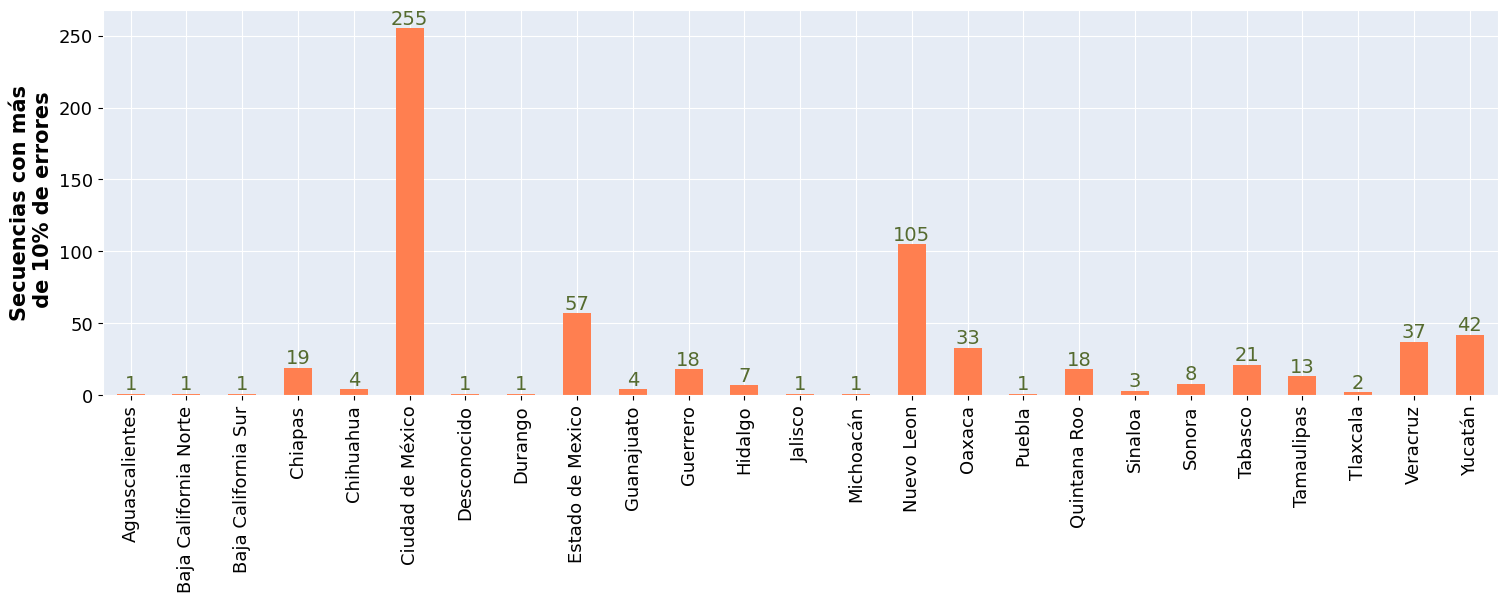

In [16]:
error_allowed = 0.1
virus_to_drop = all_genomes.query('Errors >= Codons*@error_allowed')

fig, ax = plt.subplots(figsize=(18,5))
bar = (
    virus_to_drop
    .groupby(by='State', as_index=False)
    ['Virus']
    .count()
    .sort_values('State')
    .plot.bar(x='State', y='Virus', xlabel='', legend=False,
              color='coral', ax=ax, rot=90, fontsize=13)
)
ax.bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
ax.set_ylabel('Secuencias con más\n de 10% de errores', fontdict=dict(size=15, weight='bold'))
print(f'{virus_to_drop.shape[0]} secuencias elimindadas.')

all_genomes = all_genomes.query('Errors < Codons*@error_allowed').reset_index(drop=True)
fig.savefig('Images/high_error_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/high_error_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

### • Se obtiene el uso de codones en frecuencia relativa

Una vez que se obtienen todos los genomas se obtiene la frecuencia relativa, donde el valor de cada codon se divide sobre el total de codones de cada genoma.

In [17]:
column_codons = [i for i in range(64)]
codons = all_genomes['Codons']
all_genomes.loc[:,column_codons] = all_genomes[column_codons].divide(codons, axis=0)


In [18]:
all_genomes

,Date,Virus,State,Description,0,1,2,3,...,58,59,60,61,62,63,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.035689,0.017592,0.020524,0.034375,...,0.011020,0.022647,0.026287,0.013952,0.019816,0.033667,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.035963,0.017780,0.020507,0.034246,...,0.011112,0.022528,0.026467,0.014042,0.019699,0.033842,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.035869,0.017682,0.020511,0.034253,...,0.011114,0.022532,0.026574,0.013944,0.019905,0.033849,3,9897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.036473,0.017678,0.020319,0.033933,...,0.011175,0.022757,0.026516,0.014122,0.019811,0.034034,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.036329,0.017709,0.020644,0.034001,...,0.011131,0.022667,0.026513,0.014066,0.019632,0.033900,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.036310,0.017700,0.020633,0.034085,...,0.011126,0.022656,0.026601,0.013857,0.019723,0.034287,1,9887


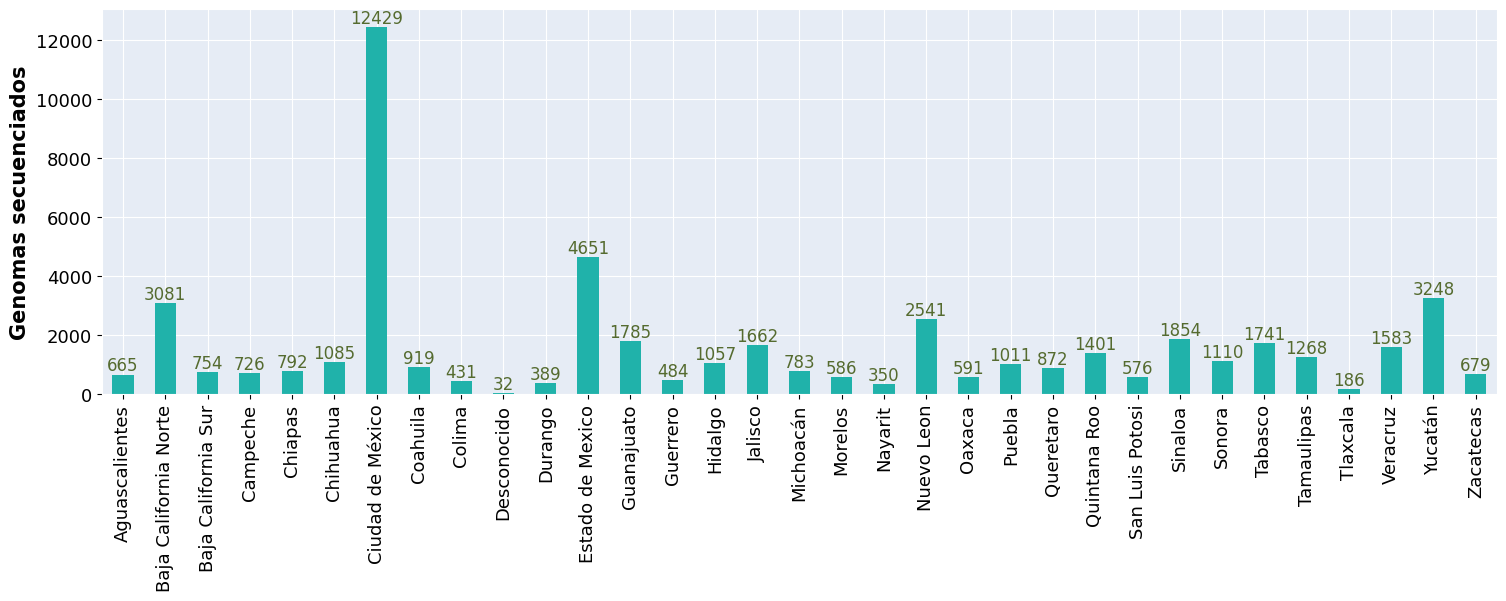

In [19]:
fig, ax = plt.subplots(figsize=(18,5))
bar = (
    all_genomes
    .groupby(by='State', as_index=False)
    ['Virus']
    .count()
    .sort_values('State')
    .plot.bar(x='State', y='Virus', xlabel='', legend=False,
              color='lightseagreen', ax=ax, rot=90, fontsize=13)
)
ax.set_ylabel('Genomas secuenciados', fontdict=dict(size=15, weight='bold'))
ax.bar_label(bar.containers[0], color='darkolivegreen', fontsize=12);
fig.savefig('Images/codon_usage_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/codon_usage_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

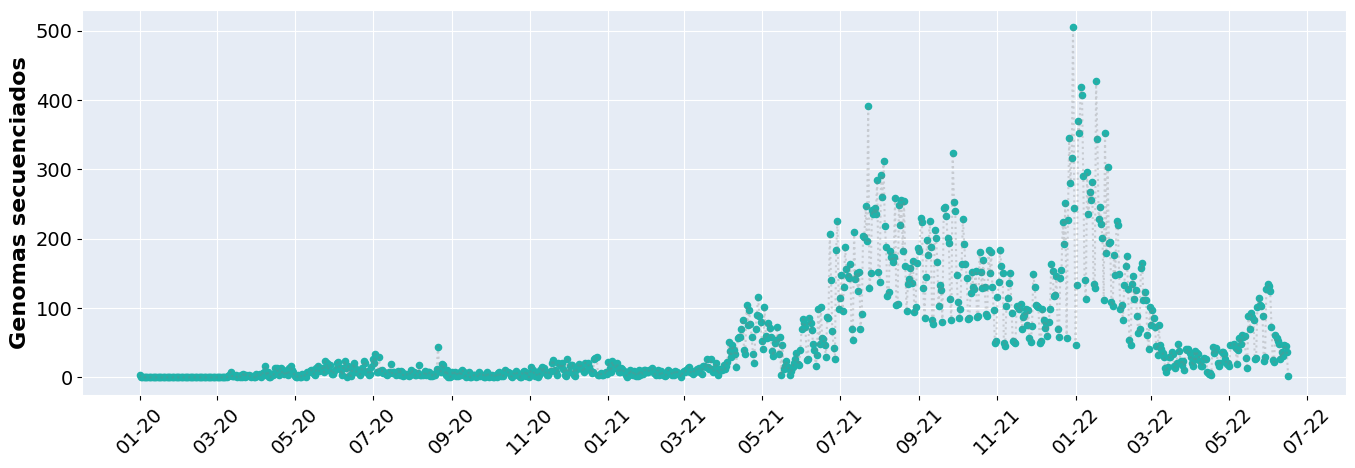

In [20]:
fig, ax = plt.subplots(figsize=(16.3,5))
temp = (
    all_genomes
    .resample('D', on='Date')
    .count()
    .reset_index()
    [['Date','Virus']]
)
# cubs_by_date.plot.line(x='Date', y='Virus', style=':', color='gray', alpha=0.5, ax=ax, legend=False)
# cubs_by_date.plot.scatter(x='Date', y='Virus', color='lightseagreen', ax=ax, fontsize=13)
# cubs_by_date
# ax.set_ylabel('Genomas secuenciados', fontdict=dict(size=15, weight='bold'))
import matplotlib.dates as mdates
locator = mdates.MonthLocator(interval=2)
formatter = mdates.DateFormatter("%m-%y")
ax.plot(temp.Date, temp.Virus, linestyle=':', color='gray', alpha=0.3)
ax.scatter(temp.Date, temp.Virus, s=20, color='lightseagreen')
ax.xaxis.set_major_locator(locator)
ax.tick_params(axis='x', labelrotation=45)
ax.tick_params(axis='both', labelsize=14)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel('Genomas secuenciados', fontdict=dict(size=16, weight='bold'));

fig.savefig('Images/codon_usage_by_date.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/codon_usage_by_date.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

### • Se Guarda la tabla generada

In [21]:
all_genomes.to_csv('Archivos/mex_genomes.csv', index=False)